In [1]:
using AgentBasedModels
using GLMakie
using Random
using Distributions
using CUDA
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1342


In [2]:
#Custom potential
function VLJ(r,ϵ,σ,expansion,fr,fa) 
        if r == 0.
            return 0
        elseif r < expansion*σ
            return -ϵ*(fr*max(σ-r,0)-fa*max(r-σ,0))
        else
            return 0
        end
end

m = @agent(3,
    [μ,σ,expansion,fr,fa,D]::Global,
    ϵ::GlobalArray,
    [∇Ux,∇Uy,∇Uz]::Local,
    cell::Identity,
    [fₚ,μon,μoff,σon,σoff]::Global, #Pseudoforces
    [idPseudo]::Identity, #Pseudoforces
    [fPseudox,fPseudoy,fPseudoz,tPseudo,active,nn,nnF,rState]::Local, #Pseudoforces
    [segregation]::Local,
    
    Equation=begin
        d(x) = -∇Ux/μ*dt + fPseudox*dt#+ 2*D*μ*dW 
        d(y) = -∇Uy/μ*dt + fPseudoy*dt#+ 2*D*μ*dW 
        d(z) = -∇Uz/μ*dt + fPseudoz*dt#+ 2*D*μ*dW 
    end,
    
    UpdateInteraction=begin
        if id.i != id.j
            r = sqrt((x.i-x.j)^2+(y.i-y.j)^2+(z.i-z.j)^2)
            ∇Ux.i += VLJ(r,ϵ[cell.i,cell.j],σ,expansion,fr,fa)*(x.i-x.j)/r
            ∇Uy.i += VLJ(r,ϵ[cell.i,cell.j],σ,expansion,fr,fa)*(y.i-y.j)/r
            ∇Uz.i += VLJ(r,ϵ[cell.i,cell.j],σ,expansion,fr,fa)*(z.i-z.j)/r
        
            #Computation of pseudoforces
            if (active.i > 0 && id.j == idPseudo.i && r < expansion*σ)
                fPseudox.i -= ϵ[cell.i,cell.j]*fₚ*(x.i-x.j)/r
                fPseudoy.i -= ϵ[cell.i,cell.j]*fₚ*(y.i-y.j)/r
                fPseudoz.i -= ϵ[cell.i,cell.j]*fₚ*(z.i-z.j)/r
                fPseudox.j += ϵ[cell.i,cell.j]*fₚ*(x.i-x.j)/r
                fPseudoy.j += ϵ[cell.i,cell.j]*fₚ*(y.i-y.j)/r
                fPseudoz.j += ϵ[cell.i,cell.j]*fₚ*(z.i-z.j)/r
            end

            #Activation and deactivation of the agents
            if r == 0.
                nn.i += 0
            elseif r < expansion*σ
                nn.i += 1
                if tPseudo.i < t
                    if rState.i*nnF.i < nn.i
                        tPseudo.i = t + σoff*Uniform(0,1)+μoff
                        active.i = active.i * (-1)
                        idPseudo.i = id.j   
                        rState.i = Uniform(0,1)
                    end  
     
                end
                
                #Add to the segregation number
                if cell.i == cell.j 
                    segregation.i += 1
                end
            else
                nn.i += 0
            end
            
        end
    end,
    
    UpdateLocal = begin
        nnF = nn
        if nn != 0
            segregation /= nn
        else
            segregation = 0
        end
    end
)
model = compile(m,platform="gpu",neighbors="grid",integrator="Euler",save="RAM");

In [3]:
l = 10
step = 1

conditions = [("cpu","grid"),("gpu","grid"),("cpu","full"),("gpu","full")]

t_list = zeros(length(conditions),round(Int,l÷step))
N_list = zeros(length(conditions),round(Int,l÷step))

for (i,r) in enumerate(range(1,l,step=step))
    
    for (j,cond) in enumerate(conditions)            
            global model = compile(m,platform=cond[1],neighbors=cond[2],integrator="Euler",save="RAM");

            eval(:(sphere(x) = sqrt((x[1])^2+(x[2])^2+(x[3])^2) < $r))

            global com = initialiseCommunityCompactHexagonal(model,[-50 50;-50 50;-50 50],.5;fExtrude=sphere);
            #com=Community(model,N=2)
            #com.x .= [0,.1]
            #com.y .= 0
            #com.z .= 0

            com.μ = 1
            com.ϵ = [1 .2;.2 1]
            com.σ = 1
            com.expansion = 1.2
            com.fr = .5
            com.fa = .2
            #com.D = .05
            com.fₚ = .1
            com.σoff = 1
            com.μoff = 0
            com.active = Int.((rand(Binomial(1,0.5),com.N) .- .5) .*2)
            com.simulationBox .= [-50 50;-50 50;-50 50]
            com.radiusInteraction = 1.

            com.cell = rand(Binomial(1,0.5),com.N) .+ 1
            
            model.evolve(com, tMax = 1, dt = .1, dtSave=1) #Force to compile

            time = @benchmark model.evolve(com, tMax = 10, dt = .1, dtSave=10)
            
            t_list[j,i] = median(time.times)
            N_list[j,i] = com.N
        
    end
end

LoadError: InvalidIRError: compiling kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceVector{Float64, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, typeof(*), Tuple{Float64, Base.Broadcast.Extruded{CuDeviceVector{Int32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Int64) resulted in invalid LLVM IR
Reason: unsupported call to an unknown function (call to julia.gpu.state_getter)
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/LLVM/wnejv/src/interop/[39m[90;4mbase.jl:45[0m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90;4mnone:0[0m
  [3] [0m[1mkernel_state[22m
[90m    @ [39m[90;4mnone:0[0m
  [4] [0m[1mexception_flag[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/YpW0k/src/device/[39m[90;4mruntime.jl:33[0m
  [5] [0m[1msignal_exception[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/YpW0k/src/device/[39m[90;4mruntime.jl:36[0m
  [6] [0m[1mthrow_boundserror[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/mVgLI/src/device/[39m[90;4mquirks.jl:4[0m
  [7] [0m[1mgetindex[22m
[90m    @ [39m[90;4mrange.jl:702[0m
  [8] [0m[1m_broadcast_getindex_evalf[22m
[90m    @ [39m[90;4mbroadcast.jl:648[0m
  [9] [0m[1m_broadcast_getindex[22m
[90m    @ [39m[90;4mbroadcast.jl:621[0m
 [10] [0m[1m#19[22m
[90m    @ [39m[90;4mbroadcast.jl:1098[0m
 [11] [0m[1mntuple[22m
[90m    @ [39m[90;4mntuple.jl:48[0m
 [12] [0m[1mcopy[22m
[90m    @ [39m[90;4mbroadcast.jl:1098[0m
 [13] [0m[1mmaterialize[22m
[90m    @ [39m[90;4mbroadcast.jl:883[0m
 [14] [0m[1mgetindex[22m
[90m    @ [39m[90;4mmultidimensional.jl:353[0m
 [15] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/GPUArrays/ymNij/src/device/[39m[90;4mindexing.jl:81[0m
 [16] [0m[1mbroadcast_kernel[22m
[90m    @ [39m[90m~/.julia/packages/GPUArrays/ymNij/src/host/[39m[90;4mbroadcast.jl:58[0m

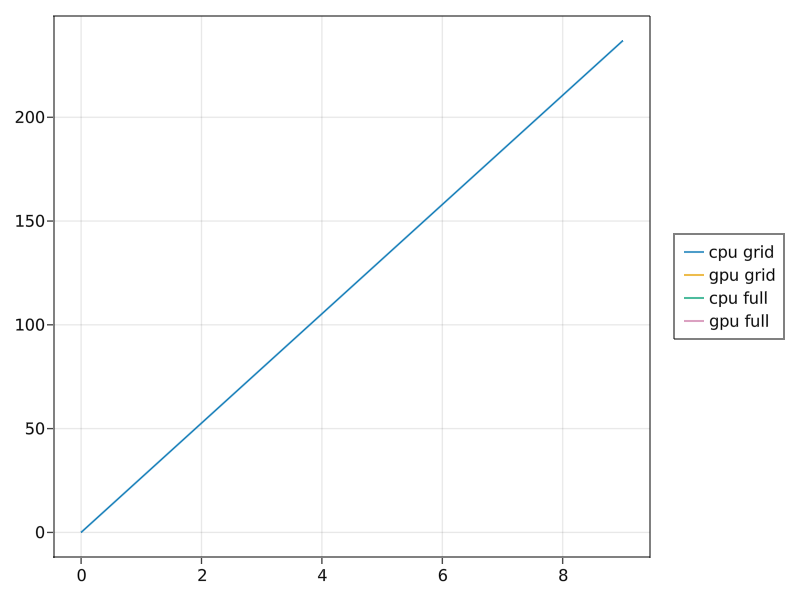

In [4]:
fig = Figure()
ax = Axis(fig[1,1])

legend = []
for i in 1:length(conditions)
    object = lines!(ax,N_list[i,:],t_list[i,:].*10^-6)
    push!(legend,object)
end

Legend(fig[1,2],legend,[string(i[1]," ",i[2]) for i in conditions])

fig

In [5]:
l = 20
step = 2

conditions = [("cpu","grid"),("gpu","grid")]

t_list = zeros(length(conditions),l÷step)
N_list = zeros(length(conditions),l÷step)

for (i,r) in enumerate(range(1,l,step=step))
    
    for (j,cond) in enumerate(conditions)            
            global model = compile(m,platform=cond[1],neighbors=cond[2],integrator="Euler",save="RAM");

            eval(:(sphere(x) = sqrt((x[1])^2+(x[2])^2+(x[3])^2) < $r))

            global com = initialiseCommunityCompactHexagonal(model,[-50 50;-50 50;-50 50],.5;fExtrude=sphere);
            #com=Community(model,N=2)
            #com.x .= [0,.1]
            #com.y .= 0
            #com.z .= 0

            com.μ = 1
            com.ϵ = [1 .2;.2 1]
            com.σ = 1
            com.expansion = 1.2
            com.fr = .5
            com.fa = .2
            #com.D = .05
            com.fₚ = .1
            com.σoff = 1
            com.μoff = 0
            com.active = Int.((rand(Binomial(1,0.5),com.N) .- .5) .*2)
            com.simulationBox .= [-50 50;-50 50;-50 50]
            com.radiusInteraction = 1.

            com.cell = rand(Binomial(1,0.5),com.N) .+ 1
            
            model.evolve(com, tMax = 1, dt = .1, dtSave=1) #Force to compile

            time = @benchmark model.evolve(com, tMax = 10, dt = .1, dtSave=10)
            
            t_list[j,i] = median(time.times)
            N_list[j,i] = com.N
        
    end
end

LoadError: InvalidIRError: compiling kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceVector{Float64, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, typeof(*), Tuple{Float64, Base.Broadcast.Extruded{CuDeviceVector{Int32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Int64) resulted in invalid LLVM IR
Reason: unsupported call to an unknown function (call to julia.gpu.state_getter)
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/LLVM/wnejv/src/interop/[39m[90;4mbase.jl:45[0m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90;4mnone:0[0m
  [3] [0m[1mkernel_state[22m
[90m    @ [39m[90;4mnone:0[0m
  [4] [0m[1mexception_flag[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/YpW0k/src/device/[39m[90;4mruntime.jl:33[0m
  [5] [0m[1msignal_exception[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/YpW0k/src/device/[39m[90;4mruntime.jl:36[0m
  [6] [0m[1mthrow_boundserror[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/mVgLI/src/device/[39m[90;4mquirks.jl:4[0m
  [7] [0m[1mgetindex[22m
[90m    @ [39m[90;4mrange.jl:702[0m
  [8] [0m[1m_broadcast_getindex_evalf[22m
[90m    @ [39m[90;4mbroadcast.jl:648[0m
  [9] [0m[1m_broadcast_getindex[22m
[90m    @ [39m[90;4mbroadcast.jl:621[0m
 [10] [0m[1m#19[22m
[90m    @ [39m[90;4mbroadcast.jl:1098[0m
 [11] [0m[1mntuple[22m
[90m    @ [39m[90;4mntuple.jl:48[0m
 [12] [0m[1mcopy[22m
[90m    @ [39m[90;4mbroadcast.jl:1098[0m
 [13] [0m[1mmaterialize[22m
[90m    @ [39m[90;4mbroadcast.jl:883[0m
 [14] [0m[1mgetindex[22m
[90m    @ [39m[90;4mmultidimensional.jl:353[0m
 [15] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/GPUArrays/ymNij/src/device/[39m[90;4mindexing.jl:81[0m
 [16] [0m[1mbroadcast_kernel[22m
[90m    @ [39m[90m~/.julia/packages/GPUArrays/ymNij/src/host/[39m[90;4mbroadcast.jl:58[0m

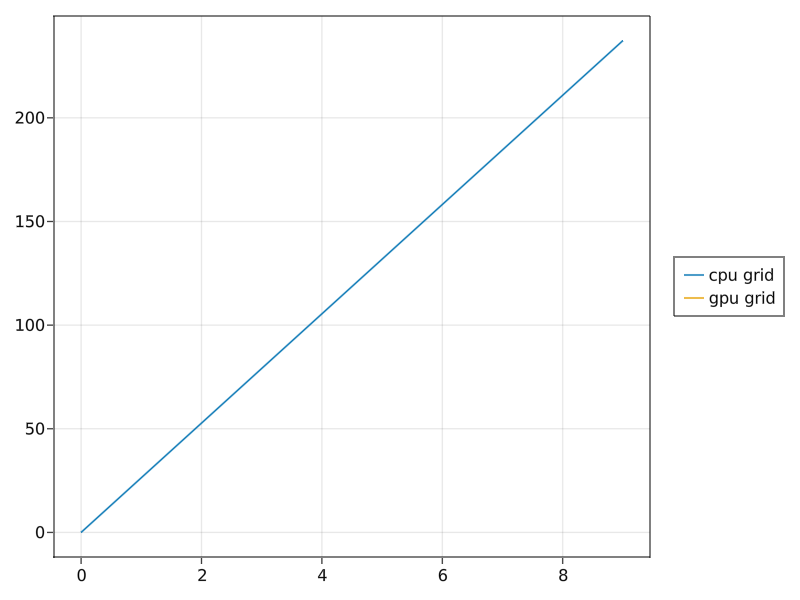

In [6]:
fig = Figure()
ax = Axis(fig[1,1])

legend = []
for i in 1:length(conditions)
    object = lines!(ax,N_list[i,:],t_list[i,:].*10^-6)
    push!(legend,object)
end

Legend(fig[1,2],legend,[string(i[1]," ",i[2]) for i in conditions])

fig